[Quant Finance with Python and Pandas | 50 Concepts you NEED to Know in 9 Minutes ](https://youtu.be/b9RgHa1CnH4?si=A-5fglupmfKs463K)

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [84]:
# Adj close is inclusive of cashflows (divs, coupons etc)
prices = yf.download(tickers=['SPY', 'BND'], interval='1mo')["Adj Close"]

[*********************100%%**********************]  2 of 2 completed


In [85]:
# prices is a price series, indexed by date

# Here we remove rows with NA val, caused by the equities starting on different dates
prices.dropna(inplace=True)
prices

,BND,SPY
Date,,
2007-05-01,45.146347,111.349373
2007-06-01,44.926052,109.250504
2007-07-01,45.354748,106.285980
2007-08-01,45.984497,107.649918
2007-09-01,46.270138,111.289505
...,...,...
2023-07-01,71.437431,456.180908
2023-08-01,70.956131,448.767059
2023-09-01,69.192329,425.977448


In [98]:
# Here we convert the indexes to reflect the granularity of the data (monthly) - this breaks stuff further down though
prices_monthly = prices.to_period('M')
prices_monthly

,BND,SPY
Date,,
2007-05,45.146347,111.349373
2007-06,44.926052,109.250504
2007-07,45.354748,106.285980
2007-08,45.984497,107.649918
2007-09,46.270138,111.289505
...,...,...
2023-07,71.437431,456.180908
2023-08,70.956131,448.767059
2023-09,69.192329,425.977448


### Rate of return (single period)
R = (Vf - Vi) / Vi

R = (Vf / Vi) - 1   # equivalent, known as 1+R format

Where:

    Vf = final value (including divs & interest)
    Vi - initial value

### Multi Period Returns

Rt1,t3 = (1 + Rt1,t2)(1 + Rt2,t3) - 1  # compound or geometric return. Accounts for variance drag

### Variance Drag

Compound returns are not additive. If a stock gained 30% one day, but lost 30% the next the arithmetic return would be 0%

  Arithmetic return  = 30 + -30 = 0%

The compound (geometric) return is:

  (1 + 0.3)(1 + -0.3)-1 = (1.3)(0.7) = 1 = 0.91 - 1 = -9%

In [86]:
# Convert price series to return series
rets = prices.pct_change().dropna()
rets

,BND,SPY
Date,,
2007-06-01,-0.004880,-0.018849
2007-07-01,0.009542,-0.027135
2007-08-01,0.013885,0.012833
2007-09-01,0.006212,0.033809
2007-10-01,0.009345,0.018376
...,...,...
2023-07-01,-0.001157,0.036569
2023-08-01,-0.006737,-0.016252
2023-09-01,-0.024858,-0.050783


<Axes: xlabel='Date'>

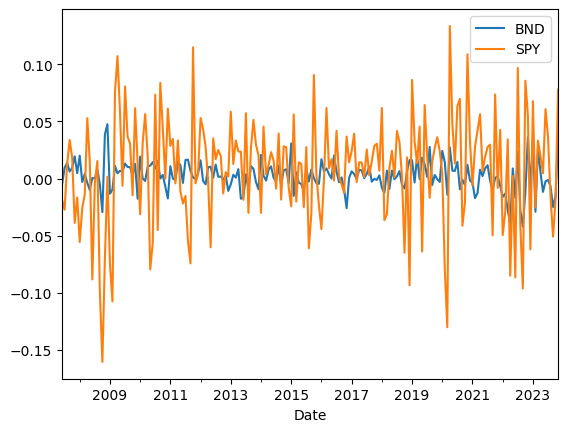

In [87]:
rets.plot()

In [88]:
# Calculate the compounded returns
compound_rets = (rets + 1).prod() - 1
(compound_rets * 100).round(2).astype('str') + '%'

BND     56.47%
SPY    304.84%
dtype: object

In [89]:
# Volatility
vol = rets.std()
vol

BND    0.013243
SPY    0.046822
dtype: float64

In [90]:
# Annualised returns
def annualize_rets(rets, periods_per_year=12):
    n_periods = rets.shape[0]
    compounded_growth = (1 + rets).prod()
    return compounded_growth ** (periods_per_year / n_periods ) - 1

In [91]:
annualize_rets(rets)

BND    0.027504
SPY    0.088442
dtype: float64

In [92]:
# Annualised Volatility
def annualize_vol(rets, periods_per_year=12):
    return rets.std() * (periods_per_year ** 0.5)

In [93]:
annualize_vol(rets)

BND    0.045875
SPY    0.162196
dtype: float64

In [94]:
# Raw Sharpe Ratio
# Sharpe Ratio is risk-adjusted return. Full SR requires risk-free rate data
annualize_rets(rets) / annualize_vol(rets)

BND    0.599546
SPY    0.545277
dtype: float64

<Axes: >

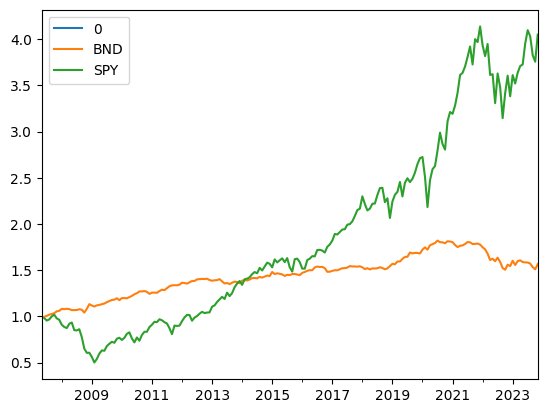

In [99]:
# Wealth Index
wealth_index = (rets + 1).cumprod()

# To start at 1 (needs daily data, don't convert to monthly as above):
start_date = wealth_index.index.min() - pd.DateOffset(months=1)
wealth_index = pd.concat([pd.Series([1], index=[start_date]), wealth_index])

wealth_index.plot()

Text(2011-02-01 00:00:00, -1.015696553230193, 'Max Drawdown: -50.78%')

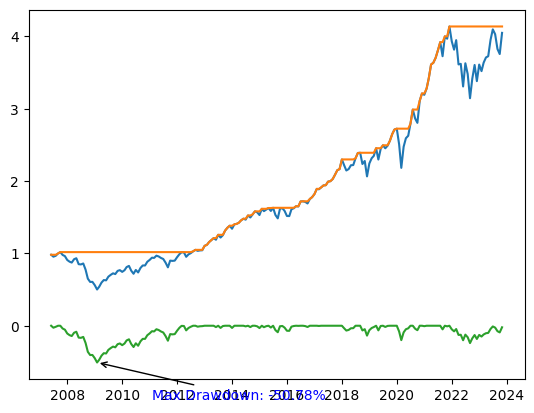

In [111]:
# Drawdowns
#  return fromn the previous peak to the current price
wealth_index_spy = wealth_index[['SPY']]

previous_peaks = wealth_index_spy.cummax() # cumulative maximum
drawdowns = (wealth_index_spy - previous_peaks) / previous_peaks

max_drawdown = drawdowns.min().item()
max_drawdown_date = drawdowns.idxmin().item()

plt.plot(wealth_index_spy)
plt.plot(previous_peaks)
plt.plot(drawdowns)

plt.annotate(f'Max Drawdown: {max_drawdown:.2%}',
             xy=(max_drawdown_date, max_drawdown),
             xytext=(max_drawdown_date + pd.DateOffset(years=2), max_drawdown * 2),
             arrowprops=dict(arrowstyle='->', lw=1), color='blue')

In [157]:
def plot_drawdowns(ticker: str):

    prices = yf.download(tickers=[ticker], interval='1mo')["Adj Close"]
    prices.dropna(inplace=True)
    rets = prices.pct_change().dropna()
    
    wealth_index = (rets + 1).cumprod()

    previous_peaks = wealth_index.cummax() # cumulative maximum
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    max_drawdown = drawdowns.min()
    max_drawdown_date = drawdowns.idxmin()

    max_val = wealth_index.max()
    max_val_date = wealth_index.idxmax()

    print(f'{max_val:.2f}: {max_val_date:%d:%m:%y}')

    plt.plot(wealth_index)
    plt.plot(previous_peaks)
    plt.plot(drawdowns)

    plt.annotate(f'Max Drawdown: {max_drawdown:.2%} {max_drawdown_date:%d:%m:%y}',
                xy=(max_drawdown_date, max_drawdown),
                xytext=(max_drawdown_date + pd.DateOffset(years=2), max_drawdown * 2),
                arrowprops=dict(arrowstyle='->', lw=1), color='blue')
    
    plt.annotate(f'Max Price: {max_val:.2f} {max_val_date:%d:%m:%y}',
                xy=(max_val_date, max_val),
                xytext=(max_val_date + pd.DateOffset(years=-20), max_val),
                arrowprops=dict(arrowstyle='->', lw=1), color='blue')

[*********************100%%**********************]  1 of 1 completed
33.98: 01:06:16


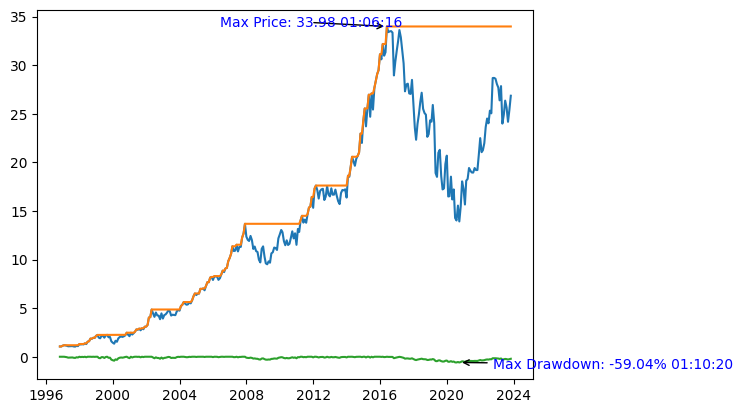

In [156]:
plot_drawdowns('IMB.L')